In [1]:
from pathlib import Path
import os, sys
from rasterstats import zonal_stats
import rasterio as rio
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/ojlarson/Documents/GitHub/modis-viirs-metric-comps/venv/lib/python3.12/site-packages/pyproj/__init__.py:96: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
project_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_path)
from config import Config
from metric_comp import MetricDataset, clip_raster
config = Config()

In [3]:
len(config.modis_metric_names) == len(config.viirs_metric_names)

True

In [4]:
year = 2015
compare_metrics_dict = {}
for i in range(0, len(config.modis_metric_names)):
    compare_metrics_dict[f"{year} Band {i + 1}"] = {}
compare_metrics_dict

{'2015 Band 1': {},
 '2015 Band 2': {},
 '2015 Band 3': {},
 '2015 Band 4': {},
 '2015 Band 5': {},
 '2015 Band 6': {},
 '2015 Band 7': {},
 '2015 Band 8': {},
 '2015 Band 9': {},
 '2015 Band 10': {},
 '2015 Band 11': {},
 '2015 Band 12': {}}

In [6]:
for i in range(0, len(config.modis_metric_names)):
    print(f"Loading MODIS metric {i + 1}: {config.modis_metric_names[i]}")
    mds = MetricDataset(config.split_modis_metric_path, i+1, year, 'modis', 'new-6', config.modis_metric_names)
    mds_array, mds_transform = mds.load_tiff()
    compare_metrics_dict[f"{year} Band {i + 1}"]["modis"] = mds_array

Loading MODIS metric 1: first_snow_day
Loading MODIS metric 2: last_snow_day
Loading MODIS metric 3: fss_range
Loading MODIS metric 4: longest_css_first_day
Loading MODIS metric 5: longest_css_last_day
Loading MODIS metric 6: longest_css_day_range
Loading MODIS metric 7: snow_days
Loading MODIS metric 8: no_snow_days
Loading MODIS metric 9: css_segment_num
Loading MODIS metric 10: mflag
Loading MODIS metric 11: cloud_days
Loading MODIS metric 12: tot_css_days


In [9]:
if mds:
    for i in range(0, len(config.modis_metric_names)):
        if config.viirs_metric_names[i] is None:
            continue
        print(f"Loading VIIRS metric {i + 1}: {config.viirs_metric_names[i]}")
        vds = MetricDataset(config.viirs_metric_path, i+1, year, 'viirs', 'v1', config.viirs_metric_names)
        vds_array, vds_transform = clip_raster(mds, vds)
        compare_metrics_dict[f"{year} Band {i + 1}"]["viirs"] = vds_array

Loading VIIRS metric 1: first_snow_day
Loading VIIRS metric 2: last_snow_day
Loading VIIRS metric 3: fss_range
Loading VIIRS metric 4: longest_css_start
Loading VIIRS metric 5: longest_css_end
Loading VIIRS metric 6: longest_css_range
Loading VIIRS metric 7: snow_days
Loading VIIRS metric 8: no_snow_days
Loading VIIRS metric 9: css_segment_num
Loading VIIRS metric 12: tot_css_days


In [10]:
stats_output_dir = '/Users/ojlarson/Documents/modis-viirs/stats_plots'

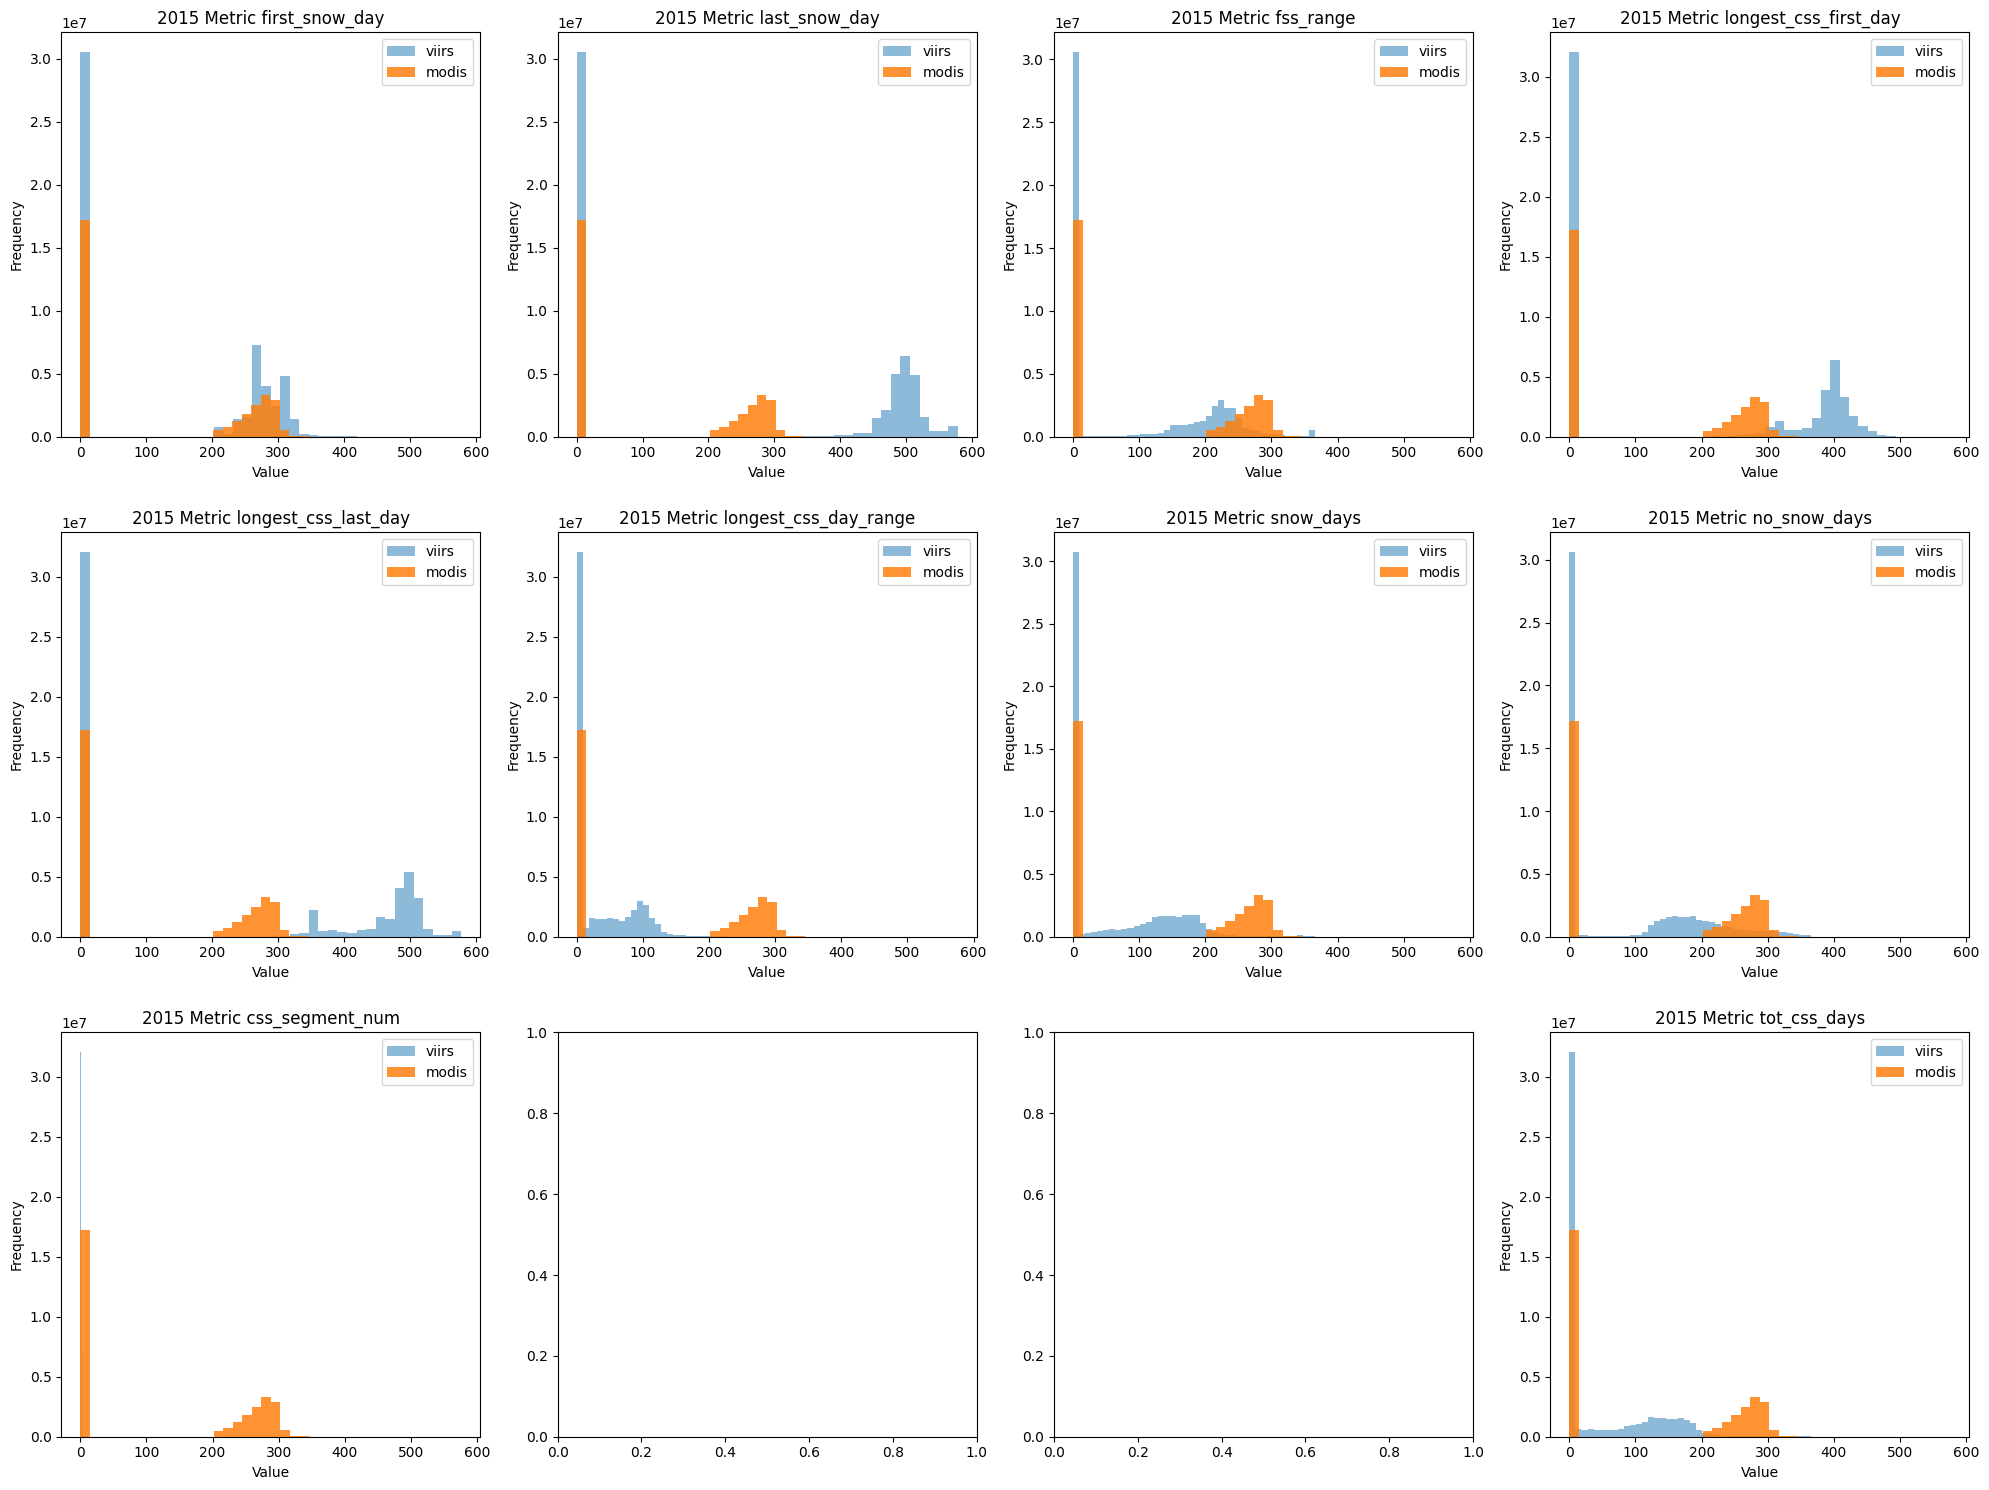

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (key, values) in enumerate(compare_metrics_dict.items()):
    # Extract the "VIIRS" and "MODIS" arrays
    try:
        viirs_metric = values['viirs']
    except:
        continue
    modis_metric = values['modis']
    
    # Calculate the histograms
    viirs_hist, viirs_bins = np.histogram(viirs_metric, bins=40)
    modis_hist, modis_bins = np.histogram(modis_metric, bins=40)

    # Plot the histograms
    axes[i].hist(viirs_metric.flatten(), bins=viirs_bins, alpha=0.5, label='viirs')
    axes[i].hist(modis_metric.flatten(), bins=modis_bins, alpha=0.85, label='modis')

    # Set title and labels for each subplot
    axes[i].set_title(f"{year} Metric {config.modis_metric_names[i]}")
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

    # Add a legend to the subplot
    axes[i].legend()


# Adjust spacing between subplots
plt.tight_layout()

# Show and savethe plot
plt.savefig(Path(stats_output_dir) / f"{year}_clipped_viirs_and_modis_histograms.png", dpi=144, bbox_inches="tight")

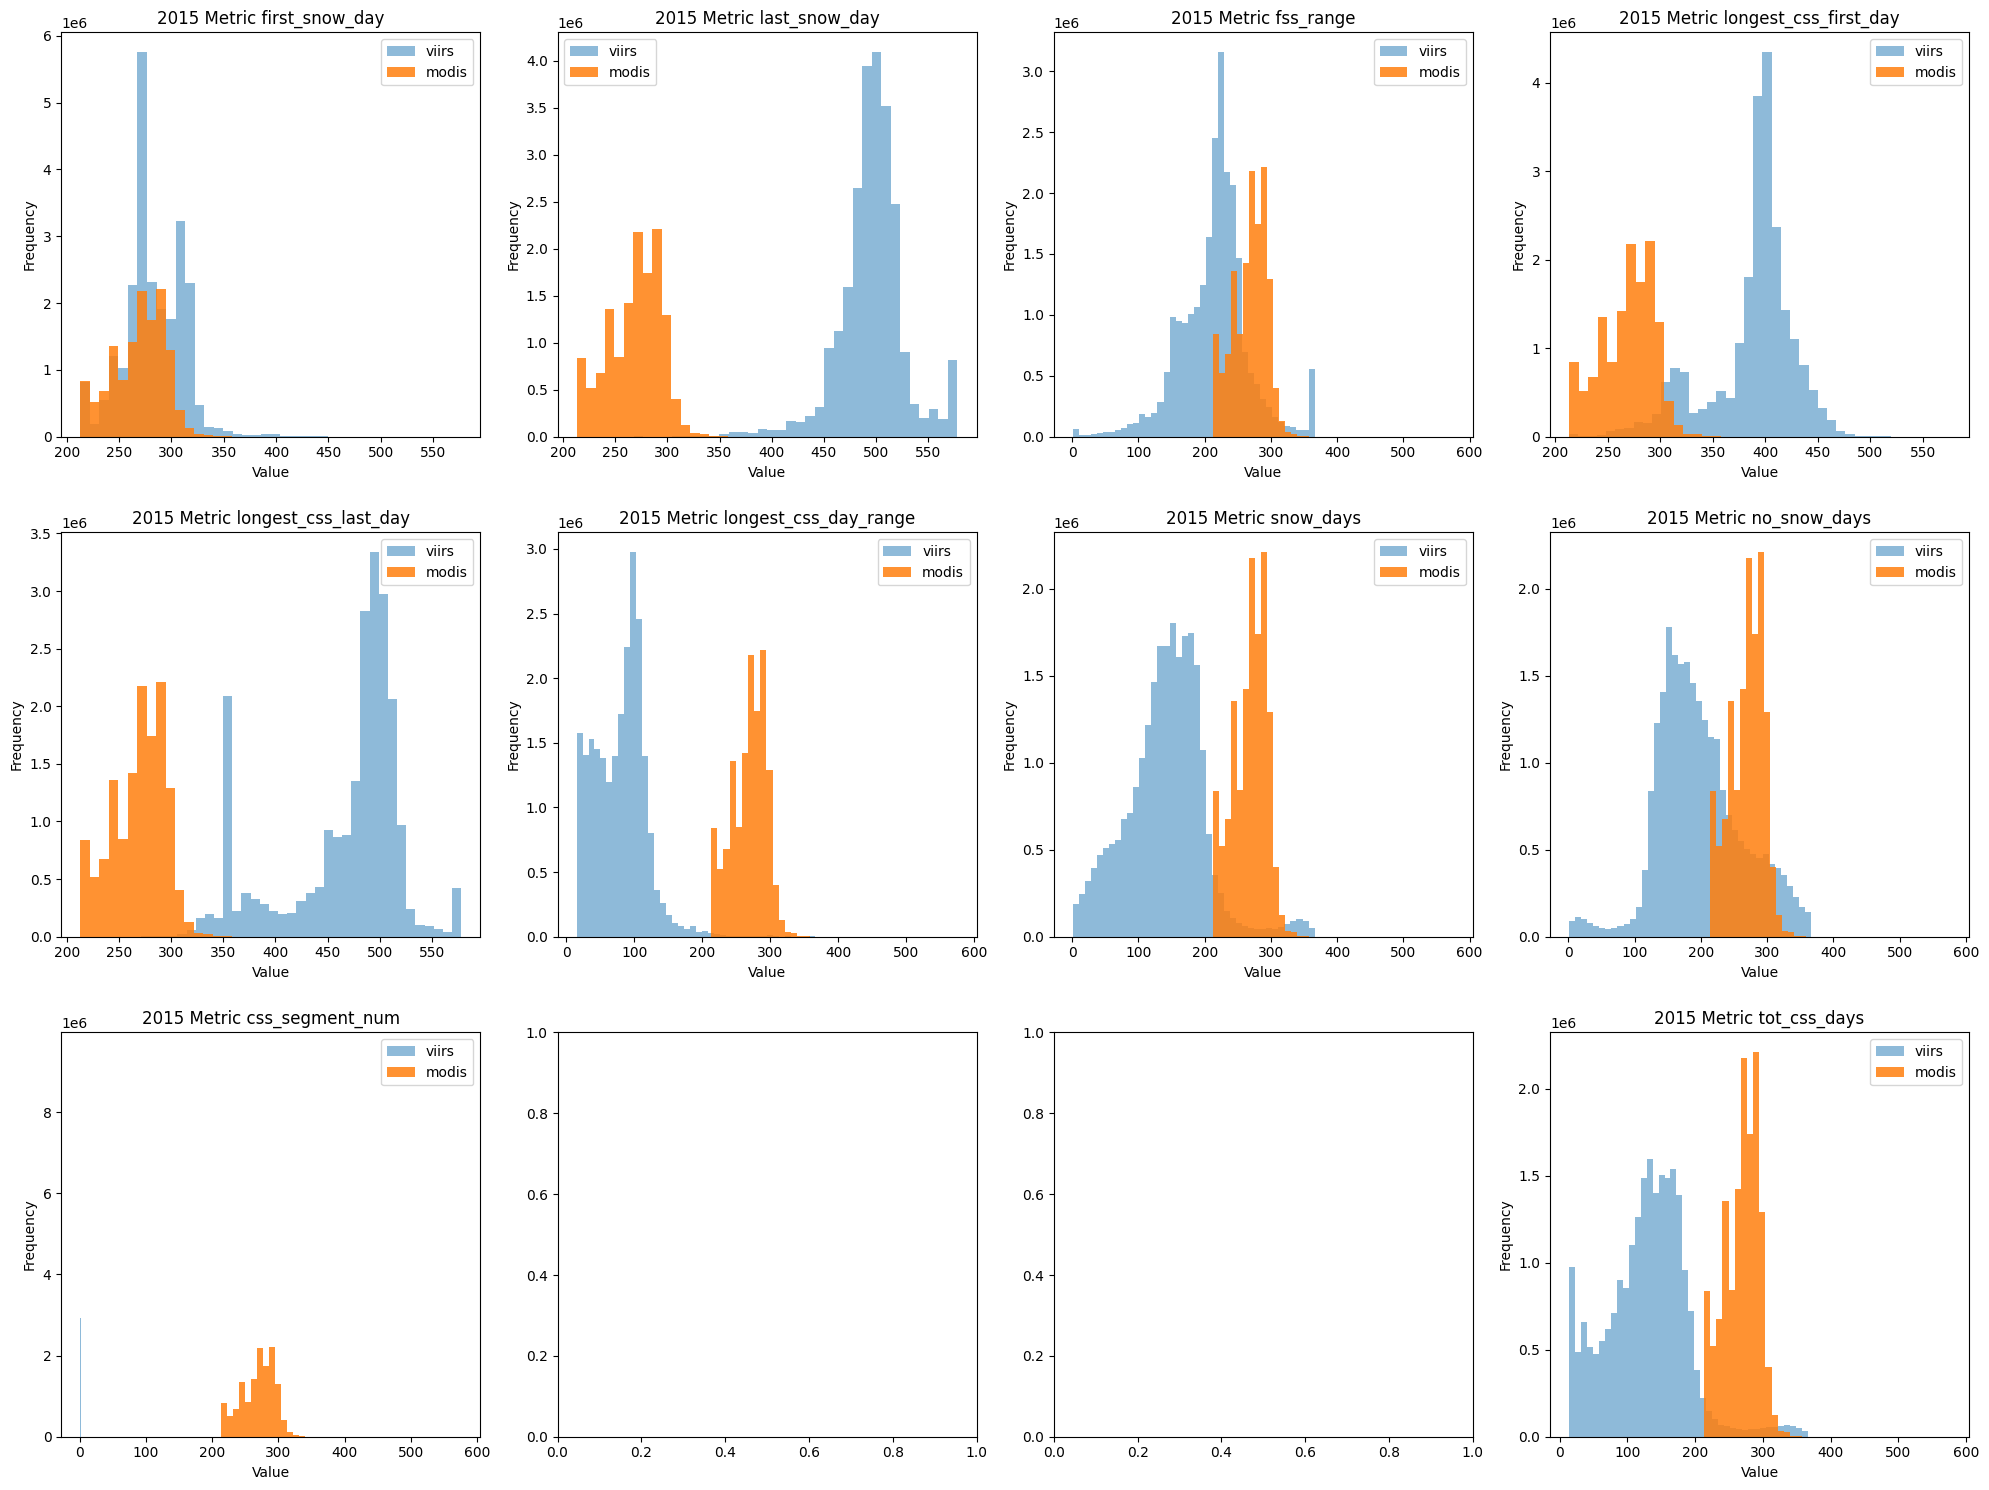

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (key, values) in enumerate(compare_metrics_dict.items()):
    # Extract the "VIIRS" and "MODIS" arrays
    try:
        viirs_metric = values['viirs']
    except:
        continue
    modis_metric = values['modis']
    
    # Remove Zeros 
    viirs_z_mask = np.nonzero(viirs_metric)
    viirs_metric = viirs_metric[viirs_z_mask]
    modis_z_mask = np.nonzero(modis_metric)
    modis_metric = modis_metric[modis_z_mask]
    
    # Calculate the histograms
    viirs_hist, viirs_bins = np.histogram(viirs_metric, bins=40)
    modis_hist, modis_bins = np.histogram(modis_metric, bins=40)

    # Plot the histograms
    axes[i].hist(viirs_metric.flatten(), bins=viirs_bins, alpha=0.5, label='viirs')
    axes[i].hist(modis_metric.flatten(), bins=modis_bins, alpha=0.85, label='modis')

    # Set title and labels for each subplot
    axes[i].set_title(f"{year} Metric {config.modis_metric_names[i]}")
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

    # Add a legend to the subplot
    axes[i].legend()


# Adjust spacing between subplots
plt.tight_layout()

# Show and save the plot
plt.savefig(Path(stats_output_dir) / f"{year}_clipped_viirs_and_modis_histograms_no_zeros.png", dpi=144, bbox_inches="tight")

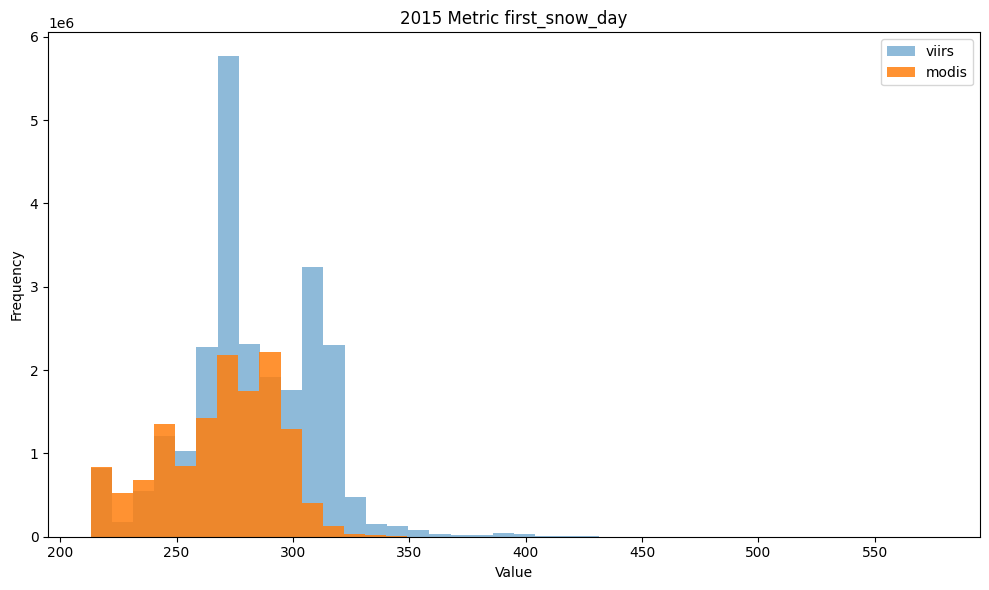

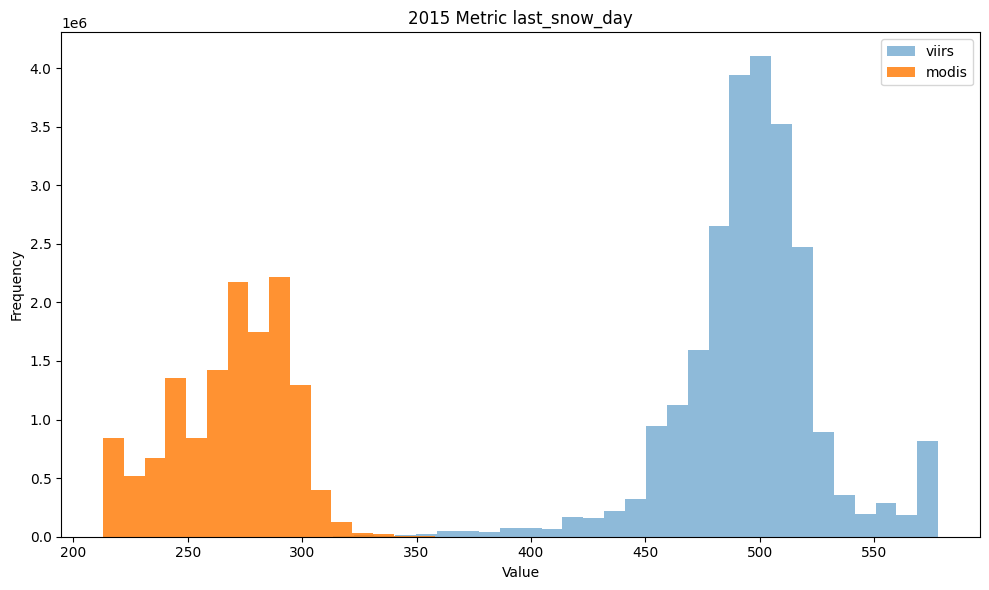

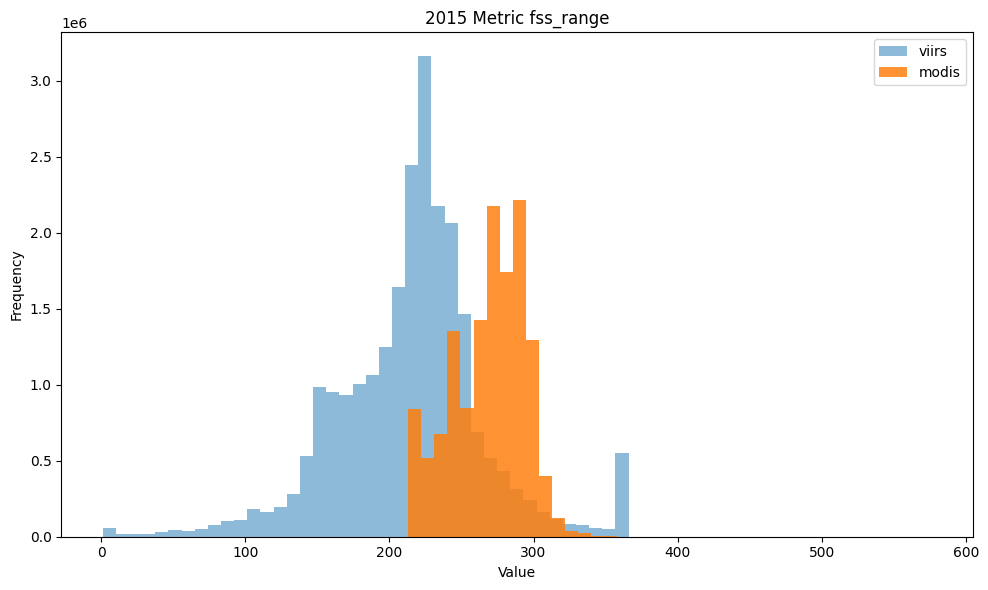

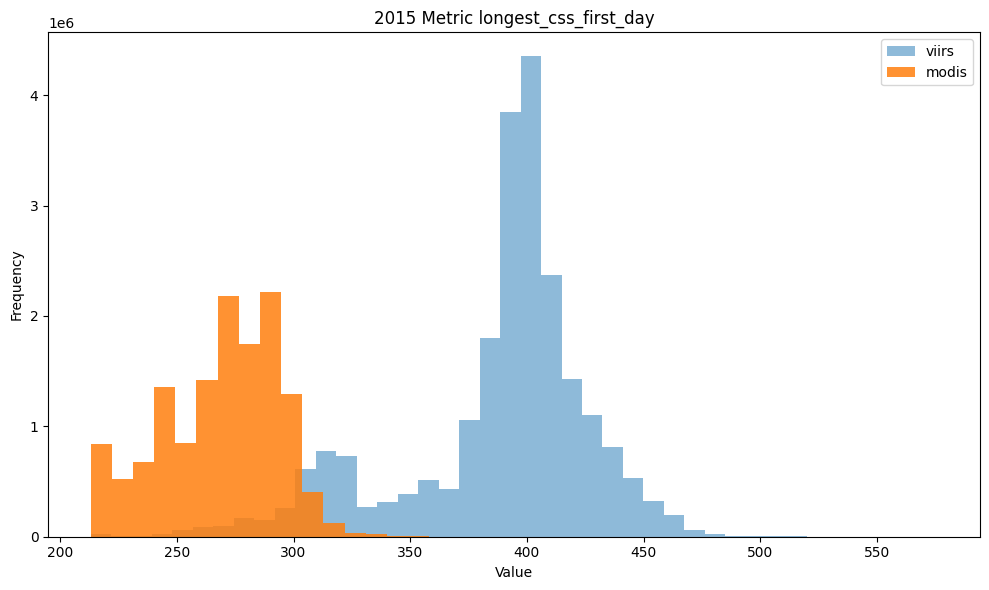

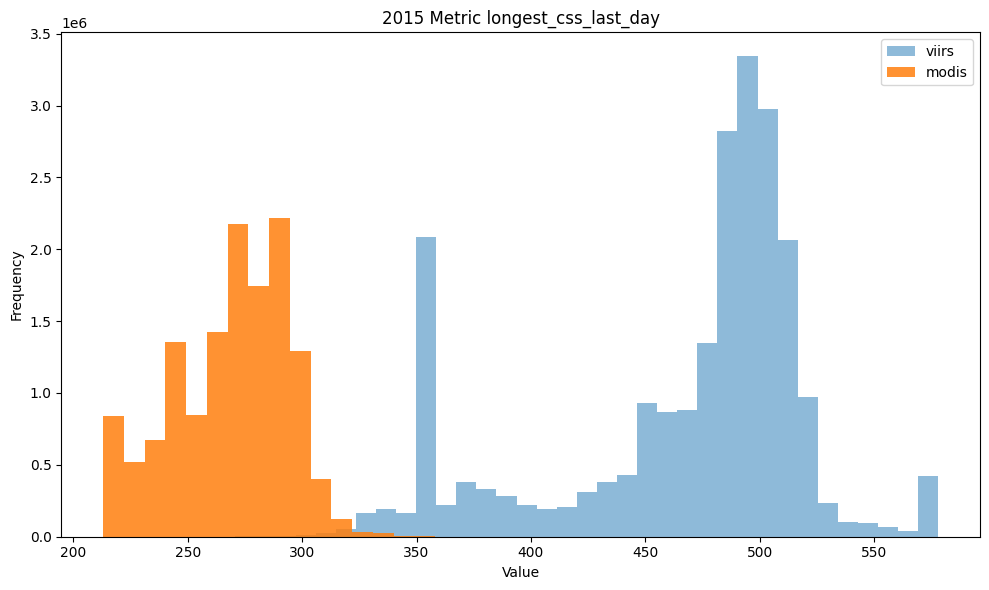

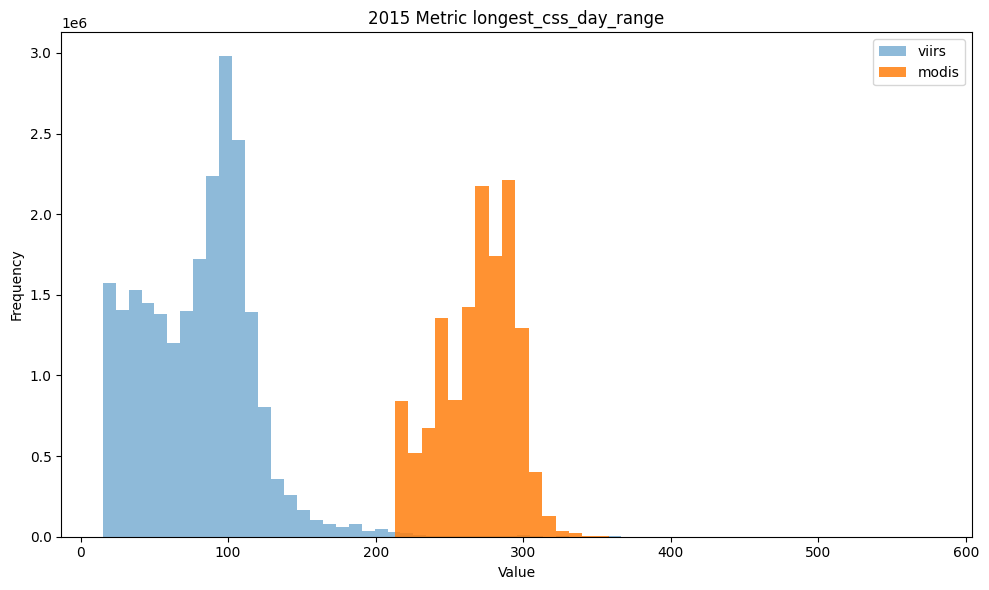

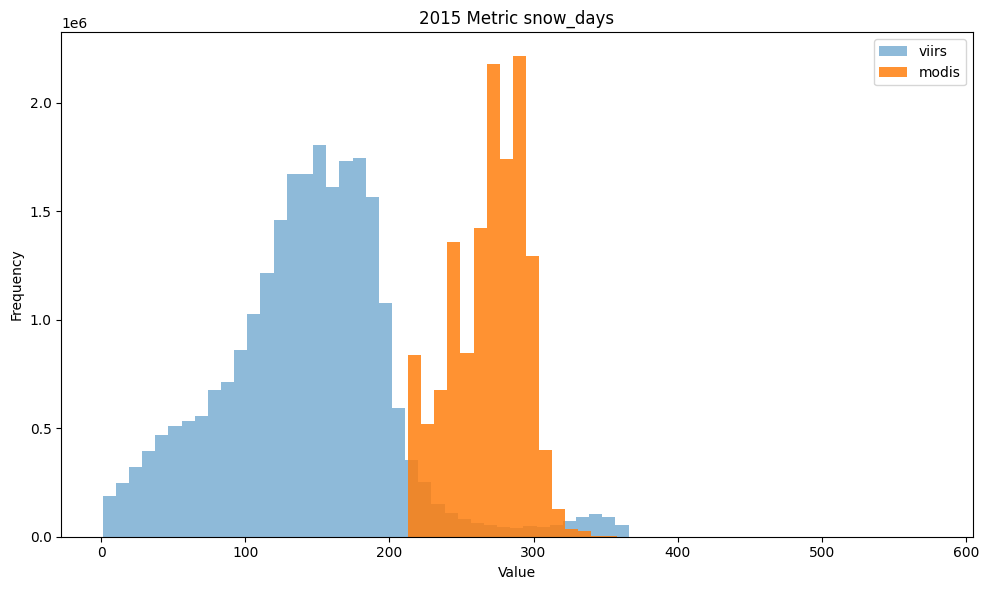

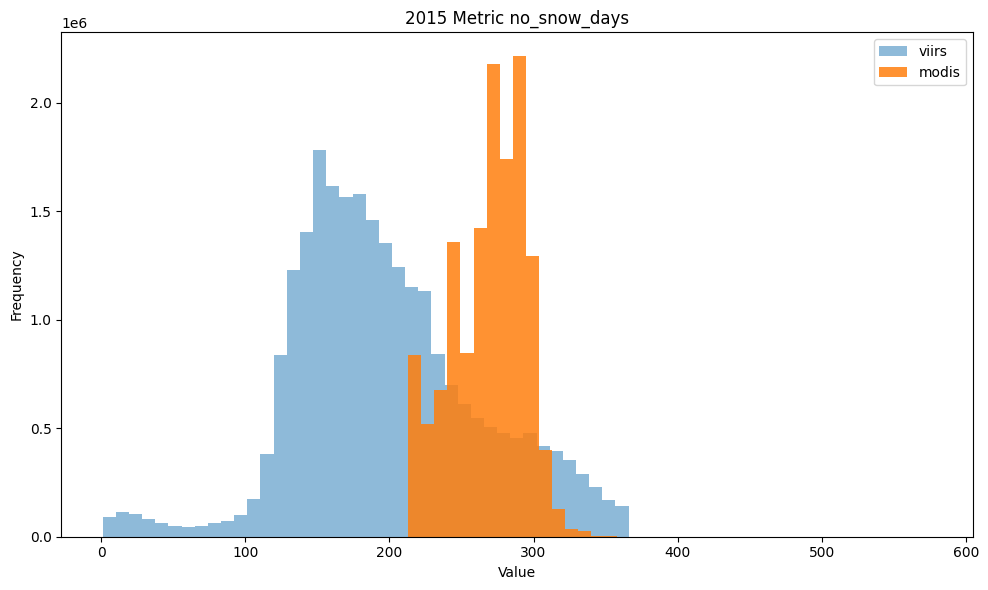

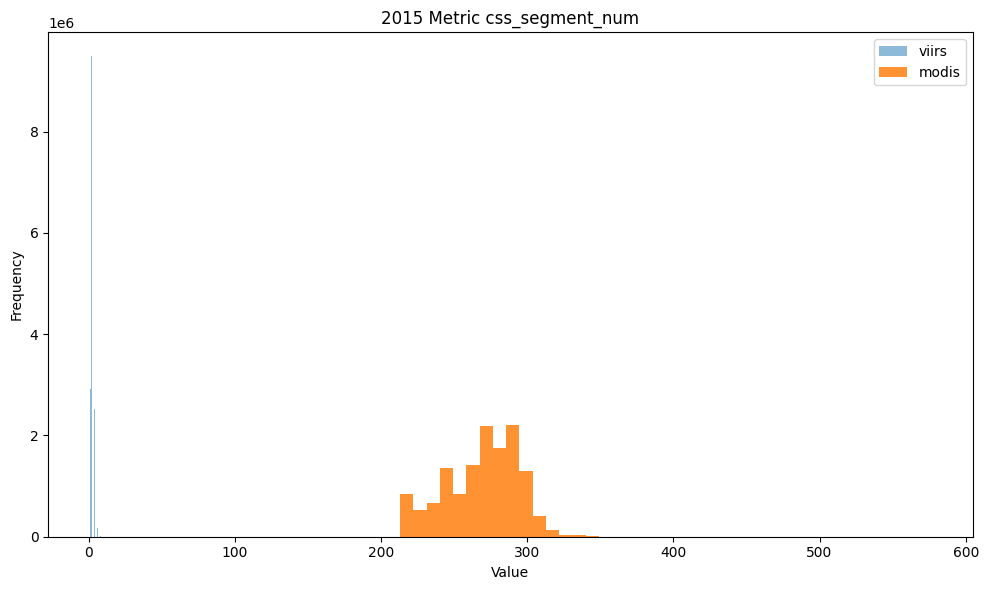

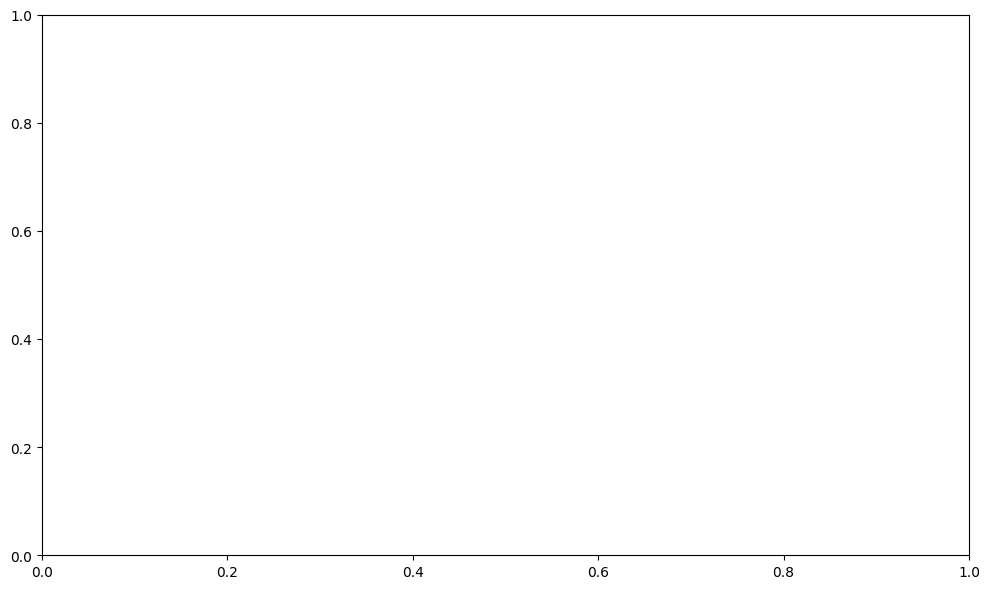

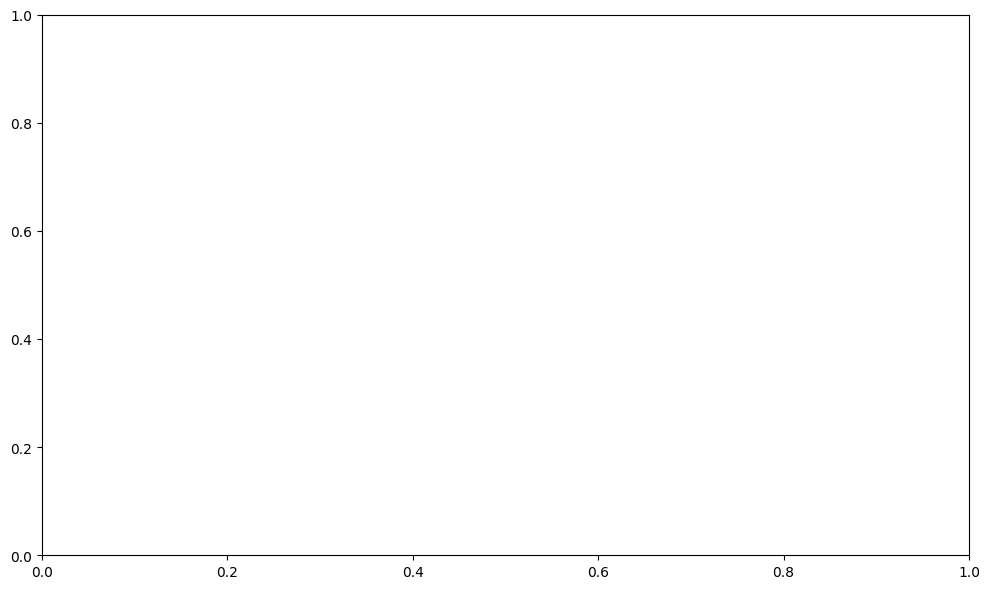

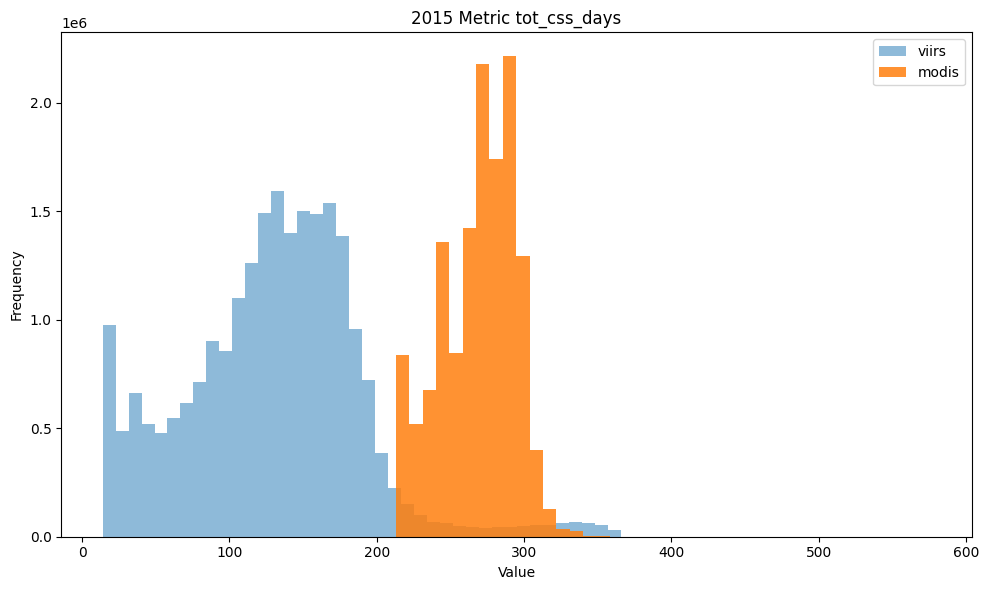

In [31]:
import matplotlib.pyplot as plt

for j in range(len(config.modis_metric_names)):
    # Create a single figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot only the histogram for the first item in the dictionary
    for i, (key, values) in enumerate(compare_metrics_dict.items()):
        if i == j:
            try:
                viirs_metric = values['viirs']
            except:
                continue
            modis_metric = values['modis']
            
            # Remove Zeros 
            viirs_z_mask = np.nonzero(viirs_metric)
            viirs_metric = viirs_metric[viirs_z_mask]
            modis_z_mask = np.nonzero(modis_metric)
            modis_metric = modis_metric[modis_z_mask]
            
            # Calculate the histograms
            viirs_hist, viirs_bins = np.histogram(viirs_metric, bins=40)
            modis_hist, modis_bins = np.histogram(modis_metric, bins=40)

            # Plot the histograms
            ax.hist(viirs_metric.flatten(), bins=viirs_bins, alpha=0.5, label='viirs')
            ax.hist(modis_metric.flatten(), bins=modis_bins, alpha=0.85, label='modis')

            # Set title and labels for each subplot
            ax.set_title(f"{year} Metric {config.modis_metric_names[i]}")
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')

            # Add a legend to the subplot
            ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
